## Colab computing infra available
### Preliminaries
#### 1. Runtime -> Change runtime type -> T4 GPU
#### 2. Upload data folder from github repository on your google drive
#### 3. Except first three cells, this notebook can be run on jupyter.
#### 4. For 3., pip install bayesian-optimization is performed in anaconda tensorflow environment.

In [ ]:
#GPU count and name
!nvidia-smi -L
!lscpu |grep 'Model name'
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'
#no.of cores each processor is having
!lscpu | grep 'Core(s) per socket:'
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "L3 cache"
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla T4 (UUID: GPU-2429e038-2c60-04b9-d3a5-5573f49827da)
Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Socket(s):                       1
Core(s) per socket:              1
Thread(s) per core:              2
L3 cache:                        45 MiB (1 instance)
MemAvailable:   12416136 kB
Avail
52G


In [ ]:
#  mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/MyDrive/BOPINN/data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# install Bayesian optimization library "https://github.com/bayesian-optimization/BayesianOptimization"
%pip install bayesian-optimization==1.4.1
from bayes_opt import BayesianOptimization,UtilityFunction

## In-built classes

### Gradient Tape

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute 1st and 2nd derivatives for the wave equation.

    Attributes:
        model: keras network model.
    """

    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__(**kwargs)

    def call(self, tx):
        """
        Computing 1st and 2nd derivatives for the wave equation.

        Args:
            tx: input variables (t, x).

        Returns:
            u: network output.
            du_dt: 1st derivative of t.
            du_dx: 1st derivative of x.
            d2u_dt2: 2nd derivative of t.
            d2u_dx2: 2nd derivative of x.
        """

        with tf.GradientTape() as g:
            g.watch(tx)
            with tf.GradientTape() as gg:
                gg.watch(tx)
                u = self.model(tx)
            du_dtx = gg.batch_jacobian(u, tx)
            du_dt = du_dtx[..., 0]
            du_dx = du_dtx[..., 1]
        d2u_dtx2 = g.batch_jacobian(du_dtx, tx)
        d2u_dt2 = d2u_dtx2[..., 0, 0]
        d2u_dx2 = d2u_dtx2[..., 1, 1]

        return u, du_dt, du_dx, d2u_dt2, d2u_dx2

### PINNs

In [ ]:
class PINN:
    """
    Build a physics informed neural network (PINN) model for the wave equation.

    Attributes:
        network: keras network model with input (t, x) and output u(t, x).
        c: wave velocity.
        grads: gradient layer.
    """

    def __init__(self, network, c):
        """
        Args:
            network: keras network model with input (t, x) and output u(t, x).
            c: wave velocity. Default is 1.
        """

        self.network = network
        self.c = c
        self.grads = GradientLayer(self.network)

    def build(self):
        """
        Build a PINN model for the wave equation.

        Returns:
            PINN model for the projectile motion with
                input: [ (t, x) relative to equation,
                         (t=0, x) relative to initial condition,
                         (t, x=bounds) relative to boundary condition ],
                output: [ u(t,x) relative to equation,
                          u(t=0, x) relative to initial condition,
                          du_dt(t=0, x) relative to initial derivative of t,
                          u(t, x=bounds) relative to boundary condition ]
        """

        # equation input: (t, x)
        tx_eqn = tf.keras.layers.Input(shape=(2,))
        # initial condition input: (t=0, x)
        tx_ini = tf.keras.layers.Input(shape=(2,))
        # boundary condition input: (t, x=-1) or (t, x=+1)
        tx_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients
        _, _, _, d2u_dt2, d2u_dx2 = self.grads(tx_eqn)

        # equation output being zero
        u_eqn = d2u_dt2 - self.c*self.c * d2u_dx2
        # initial condition output
        u_ini, du_dt_ini, _, _, _ = self.grads(tx_ini)
        # boundary condition output
        u_bnd = self.network(tx_bnd)  # dirichlet
        #_, _, u_bnd, _, _ = self.grads(tx_bnd)  # neumann

        # build the PINN model for the wave equation
        return tf.keras.models.Model(
            inputs=[tx_eqn, tx_ini, tx_bnd],
            outputs=[u_eqn, u_ini, du_dt_ini, u_bnd])

### Network for PINN

In [ ]:
class Network:
    """
    Build a physics informed neural network (PINN) model for the wave equation.
    """

    @classmethod
    def build(cls, num_inputs=2, layers=[64, 128, 128, 128, 128, 64], activation='tanh', num_outputs=1):
        """
        Build a PINN model for the wave equation with input shape (t, x) and output shape u(t, x).

        Args:
            num_inputs: number of input variables. Default is 2 for (t, x).
            layers: number of hidden layers.
            activation: activation function in hidden layers.
            num_outpus: number of output variables. Default is 1 for u(t, x).

        Returns:
            keras network model.
        """

        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation,
                kernel_initializer='he_normal')(x)
            x = tf.keras.layers.Dropout(0.1)(x)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(x)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

### Optimizer for PINN

In [ ]:
import scipy.optimize

class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.

    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: logging metrics.
        progbar: progress bar.
    """

    def __init__(self, model, x_train, y_train, m=10, factr=1e7, pgtol=1e-5,
                 epsilon=1e-8, maxiter=5000, maxls=50):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.pgtol = pgtol
        self.epsilon = epsilon
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.

        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.

        Args:
            x: input data.

        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.

        Args:
            weights: flatten weights.

        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.

        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)

        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate,
                                      x0=initial_weights,
                                      factr=self.factr,
                                      pgtol=self.pgtol,
                                      epsilon=self.epsilon,
                                      m=self.m,
                                      maxls=self.maxls,
                                      maxiter=self.maxiter,
                                      callback=self.callback)

        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()


## Upload data (snapshot observation)

Files in directory ['u_analytic_c=0.2t=0.25snr=39.36.mat', 'u_analytic_c=0.55t=0.25snr=38.91.mat', 'u_analytic_c=0.85t=0.25snr=37.5.mat']
Imported file u_analytic_c=0.2t=0.25snr=39.36.mat


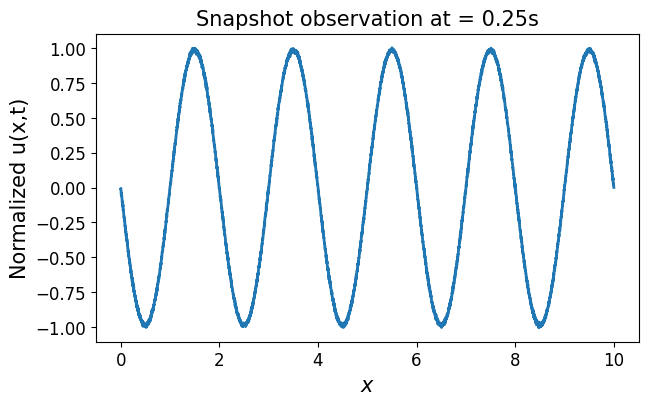

In [ ]:
#from bayes_opt import BayesianOptimization, UtilityFunction
import math
import scipy.io
import os
from os.path import join
import time

# number of training samples: found 25000 points is optimal for the resolution of u(x,t) in PINN
num_train_samples = 25000

# number of test samples
num_test_samples = 5000

# Other variables
L = 10
n = L
T = 1

# define x,t for PINNs prediction
x_test = np.linspace(0,L,num_test_samples)
t_test = np.linspace(0,T,num_test_samples)

# upload the snapshot observation
dir_list = os.listdir(path)                 # path defined in 2 cell
print("Files in directory",dir_list)
idx_data = 0 # 0,1,2                        # which file
data = dir_list[idx_data]
print("Imported file", data)

file = join(path, data)
u_analy = scipy.io.loadmat(file)
u_analy = u_analy['a1']

# plot the snapshot observation
fig = plt.figure(figsize=(7,4))
plt.plot(x_test,u_analy, '-', linewidth = 2)
plt.title("Snapshot observation at = 0.25s",fontsize=15)
plt.xlabel('$x$', fontsize = 15)
plt.ylabel('Normalized u(x,t)', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# time of observation = for PINN prediction of u(x,t) at tilde_t
tilde_t = 0.25

## Collocation points

In [ ]:
#%% Initial conditions
def u0(t):
    z = -np.sin(1*math.pi*t)
    return z

def du0_dt(tx):
    with tf.GradientTape() as g:
        g.watch(tx)
        u = u0(tx)
    du_dt = g.batch_jacobian(u, tx)[..., 0]
    return du_dt

def RMS(S):
    rms = np.sqrt(np.mean(S**2))
    return rms

#%% collocation points
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)
tx_eqn[..., 0] = T*tx_eqn[..., 0]                      # t =  0 ~ +1
tx_eqn[..., 1] = L*tx_eqn[..., 1]                      # x = 0 ~ +10
#print('\nShape of t_eqn ==>',tx_eqn.shape)

tx_ini = np.random.rand(num_train_samples, 2)
tx_ini[..., 0] = 0                                     # t = 0
tx_ini[..., 1] = L*tx_ini[..., 1]                      # x = 0 ~ +10
#print('\nShape of tx_ini ==>',tx_ini.shape)

tx_bnd = np.random.rand(num_train_samples, 2)
tx_bnd[..., 0] = T*tx_bnd[..., 0]                      # t =  0 ~ +1
tx_bnd[..., 1] = L*np.round(tx_bnd[..., 1])            # x =  0 or +10
#print('\nShape of tx_bnd ==>',tx_bnd.shape)

# initial and boundary conditions
u_zero = np.zeros((num_train_samples, 1))
u_ini = u0(tx_ini[:,1,None])
du_dt_ini = np.zeros((num_train_samples, 1))

## Target function or objective function for BOPINN

In [ ]:
#%% Target function or ojective function, g(c) = (u_pred - u_true)^2; u_pred via PINNs
def model_builder(ic):
    #ic = hp.Float('ic', min_value=0.1, max_value=1, step=10)
    print('\n ## ->>>> PINNs simulation at speed = ' + str(ic))

    # build a PINN model
    network = Network.build()
    pinn = PINN(network,ic).build()

    # train the model using L-BFGS-B algorithm
    begin = time.time()
    x_train = [tx_eqn, tx_ini, tx_bnd]
    y_train = [u_zero, u_ini, du_dt_ini, u_zero]
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()
    end = time.time()
    totaltime = end-begin
    print("\n Total runtime is (min.)",totaltime/60)

    # test the model
    tx = np.stack([np.full(t_test.shape, tilde_t), x_test], axis=-1)
    u_pred = network.predict(tx, batch_size=num_test_samples)

    # mse between u_pred via PINN and snapshot observation
    mse = -np.mean(np.square(u_analy - u_pred))

    del network, pinn, lbfgs, u_pred

    return mse

## Training

In [ ]:
#%% Bayesian Optimization
# Attributes of BO
itt_explore = 5
itt = 45
itt_all = itt_explore + itt
n_runs = 10 # reduce this if colab has limited capability

# bounds of BO
pbounds = {'ic': (0.1, 1)}

# Start BO
mse_star_all = []
cstar_all = []
mse_all_all = []
ic_all_all = []

for r in range(n_runs):
    print('\n ## ->>>> Run =  ' + str(r))

    # define the model
    optimizer = BayesianOptimization(
        f=model_builder,
        pbounds=pbounds,
        allow_duplicate_points=True)

    # utility function
    util = UtilityFunction(kind='ucb',
                           kappa=2.576,
                           xi=0.0,
                           kappa_decay=1,
                           kappa_decay_delay=0)

    # run the model
    optimizer.maximize(init_points=itt_explore,
                       n_iter=itt,
                       acquisition_function=util)

    soln = optimizer.max
    resi = optimizer.res

    # optimum values
    mse_star = list(soln.values())[0]
    cstar = list(soln.values())[1]
    cstar2 = list(cstar.values())[0]

    # append all optimum values
    mse_star_all.append(mse_star)
    cstar_all.append(cstar2)

    # all run values
    mse_all, ic_all = [], []
    for i,res in enumerate(resi):
        mse = list(res.values())[0]
        ic = list(res.values())[1]
        ic2 = list(ic.values())[0]

        # append all run values
        mse_all.append(mse)
        ic_all.append(ic2)

    mse_all_all.append(np.array(mse_all))
    ic_all_all.append(np.array(ic_all))

    del optimizer

mse_all_all = np.array(mse_all_all)
mse_star_all = np.array(mse_star_all)
ic_all_all = np.array(ic_all_all)
cstar_all = np.array(cstar_all)


 ## ->>>> Run =  0
|   iter    |  target   |    ic     |
-------------------------------------

 ## ->>>> PINNs simulation at speed = 0.4372813898716186
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 523s 105ms/step

 Total runtime is (min.) 8.710416158040365
1/1 [==============================] - 0s 127ms/step
| 1         | -0.001148 | 0.4373    |

 ## ->>>> PINNs simulation at speed = 0.353260871860698
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 457s 91ms/step

 Total runtime is (min.) 7.620774328708649
1/1 [==============================] - 0s 108ms/step
| 2         | -0.000404 | 0.3533    |

 ## ->>>> PINNs simulation at speed = 0.9598970605863492
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 1106s 221ms/step

 Total runtime is (min.) 18.436524299780526
1/1 [==============================] - 0s 105ms/step
| 3         | -0.03358  | 0.9599    |

 ## ->>>> PINNs simulation at speed 


 Total runtime is (min.) 8.373841834068298
1/1 [==============================] - 0s 109ms/step
| 5         | -7.06e-05 | 0.158     |

 ## ->>>> PINNs simulation at speed = 0.35322383568991045
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 616s 123ms/step



 Total runtime is (min.) 10.258907715479532
1/1 [==============================] - 0s 107ms/step
| 6         | -0.000410 | 0.3532    |

 ## ->>>> PINNs simulation at speed = 0.6265603597846434
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 702s 140ms/step

 Total runtime is (min.) 11.704780928293864
1/1 [==============================] - 0s 105ms/step
| 7         | -0.005768 | 0.6266    |

 ## ->>>> PINNs simulation at speed = 0.10004206006951194
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 364s 73ms/step

 Total runtime is (min.) 6.072018718719482
1/1 [==============================] - 0s 112ms/step
| 8         | -0.000105 | 0.1       |

 ## ->>>> PINNs simulation at speed = 0.25506179377329546
Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 443s 89ms/step

 Total runtime is (min.) 7.377660123507182
1/1 [==============================] - 0s 83ms/step
| 9         | -9.066e-0 | 0.2551   

## Processing and plotting

In [ ]:
#%% Process the BO results
# max, min, mean and sd target function/objective function value across different runs
max_mse_star_allruns, min_mse_star_allruns = np.max(mse_star_all), np.min(mse_star_all)
mean_mse_star_allruns, std_mse_star_allruns = np.mean(mse_star_all), np.std(mse_star_all)

# optima corresponding to abovementioned optimal points
idx_max_mse_star_allruns = np.where(max_mse_star_allruns == mse_star_all)
idx_min_mse_star_allruns = np.where(min_mse_star_allruns == mse_star_all)

max_cstar_allruns = cstar_all[idx_max_mse_star_allruns]
min_cstar_allruns = cstar_all[idx_min_mse_star_allruns]
mean_cstar_allruns = np.mean(cstar_all)
std_cstar_allruns = np.std(cstar_all)

print("Max (best optimal) tf across runs = ",max_mse_star_allruns)
print("Min (worst optimal) tf across runs = ",min_mse_star_allruns)
print("Mean tf across runs = ",mean_mse_star_allruns)
print("Std tf across runs = ",std_mse_star_allruns)

print("Max (best optimal) c* across runs = ",max_cstar_allruns)
print("Min (worst optimal) c* across runs = ",min_cstar_allruns)
print("Mean c* across runs = ",mean_cstar_allruns)
print("Std c* across runs = ",std_cstar_allruns)

In [ ]:
# plot best optimal run with the optima
idx_max_all = []
for i in range(mse_all_all.shape[0]):
    idx_max = np.where(mse_all_all[i,:] == mse_star_all[i])
    idx_max = idx_max[0][0]
    idx_max_all.append(idx_max)

mean_mse_all = np.mean(mse_all_all, axis=0)
std_mse_all = np.std(mse_all_all, axis=0)
mean_ic_all = np.mean(ic_all_all, axis=0)
std_ic_all = np.std(ic_all_all, axis=0)

opt_mse_run = mse_all_all[idx_max_mse_star_allruns[0][0]]
opt_c_run = ic_all_all[idx_max_mse_star_allruns[0][0]]
opt_mse = mse_star_all[idx_max_mse_star_allruns[0][0]]
opt_c = cstar_all[idx_max_mse_star_allruns[0][0]]

txt = 'c* = '+ str(round(opt_c,4))
plt.figure(figsize = (8, 6))
plt.plot(opt_c_run,opt_mse_run,'ob',markersize=6)
plt.plot(opt_c,opt_mse,'*r',markersize=8, label = 'Best optima')
#plt.text(0.75, -0.03, txt, fontsize=18, c = 'r')
plt.xlabel("velocity, c",fontsize=20)
plt.ylabel("target function, g(c)",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 14, loc='upper left')
plt.savefig('tfvsc_'+str(idx_data+1)+'.png', bbox_inches='tight', dpi=600)
plt.show()